In [2]:
path = "/Users/inchani/Desktop/UC\ Davis/My\ Courses/STA\ 250\ (AstroStatistics)/HW/HW2"
run(`head $path/wmap_lcdm_wmap9_chains_v5/omegach2`);
nlines = countlines("$path/wmap_lcdm_wmap9_chains_v5/omegach2");

nchain = 100_000
omega_b_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/omegabh2")[1:nchain,2]
omega_cdm_chain   = readdlm("$path/wmap_lcdm_wmap9_chains_v5/omegach2")[1:nchain,2]
tau_reio_chain    = readdlm("$path/wmap_lcdm_wmap9_chains_v5/tau")[1:nchain,2]
theta_s_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/thetastar")[1:nchain,2]
A_s_109_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/a002")[1:nchain,2]  # <-- 10⁹ * A_s
n_s_chain         = readdlm("$path/wmap_lcdm_wmap9_chains_v5/ns002")[1:nchain,2]

full_chain        = hcat(omega_b_chain, omega_cdm_chain, tau_reio_chain, theta_s_chain, A_s_109_chain, n_s_chain);
names_chain       = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s];

Σwmap             = cov(full_chain);

using Distributions

using HDF5
bandpowers = h5read("$path/bandpowers.h5", "bandpowers");

const σ² = (10.0/3437.75)^2;    # <---10μkarcmin noise level converted to radian pixels (1 radian = 3437.75 arcmin)
const b² = (0.0035)^2;          # <-- pixel width 0.2ᵒ ≈ 12.0 armin ≈ 0.0035 radians          

using PyCall
@pyimport pypico
const picoload = pypico.load_pico("$path/pico3_tailmonty_v34.dat")


function pico(x)     
    omega_b     = x[1]
    omega_cdm   = x[2]
    tau_reio    = x[3]
    theta_s     = x[4]
    A_s_109     = x[5]
    n_s         = x[6]
    plout::Dict{ASCIIString, Array{Float64,1}} = picoload[:get](;
        :re_optical_depth => tau_reio,
        symbol("scalar_amp(1)") =>  1e-9*A_s_109,
        :theta => theta_s,
        :ombh2 => omega_b,
        :omch2 => omega_cdm,
        symbol("scalar_spectral_index(1)") => n_s,
        :massive_neutrinos => 3.04,
        :helium_fraction => 0.25,
        :omnuh2 => 0.0,
        symbol("scalar_nrun(1)") => 0.0,
        :force     => true
    )
    clTT::Array{Float64,1} = plout["cl_TT"]
    ells   = 0:length(clTT)-1
    clTT .*= 2π ./ ells ./ (ells + 1)
    clTT[1] = 0.0
    return clTT
end

1       0.117062874352432095
2       0.108967379062375080
3       0.109528409355401521
4       0.101409184716838671
5       0.104083078229435091
6       0.107187006794221051
7       0.112446837434475005
8       0.107616613742339856
9       0.111562053244599030
10      0.111868995879391156


pico (generic function with 1 method)

In [137]:
function LogPost(θ)
    ClTT = pico(θ)
    ell  = 0:length(ClTT)-1
    Cldd = ClTT + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
    rtn = 0.0
    @inbounds for l in ell[2:end]
      rtn -= log(Cldd[l+1]) * (2l+1) / 2
      rtn -= (bandpowers[l+1] / Cldd[l+1]) * (2l+1) / 2
    end
    return rtn
end


function Pprop(θ1::Array{Float64,1},θ2::Array{Float64,1})
    d = length(θ1)
    return exp(-0.5 .* transpose(θ1-θ2) * (Σwmap\ (θ1-θ2))) ./ √( (2π)^d * det(Σwmap))
end

function MH(θ₀::Array{Float64,1}, N::Int64, g=1.)
    
    d      = length(θ₀)
    θcurr  = θ₀
    θ      = Array(Float64, N, d)
    αhist  = Array(Float64, N-1)    
    uhist  = Array(Float64, N-1)    
    θ[1,:] = θ₀[:]
    
    Lwmap  = chol(g * Σwmap, Val{:L})
    
    if N > 1 
        for i = 2:N    
            θprop = θcurr  .+ Lwmap * randn(d)   # < Problem here ?
            u = log(rand())
            α = min( LogPost(θprop) - LogPost(θcurr), 0.) # Log scale  & Problem here ?
            # Assume Gaussian Proposal (Symmetric) -> No need to have proposal
            
            if u <= α
                θ[i,:] = θprop[:]
                θcurr  = θprop
            else
                θ[i,:] = θcurr[:]
            end
            αhist[i-1] = α
            uhist[i-1] = u

        end
    end
    return αhist, uhist, θ
end

#θprop =  transpose(rand( MultivariateNormal(zeros(d), g * Σwmap) )) + θcurr  # < Problem here ?
#α = min(exp(LogPost(θprop)-LogPost(θcurr)) * Pprop(θcurr,θprop) / Pprop(θprop,θcurr) ,1.)[1]           

MH (generic function with 2 methods)

In [152]:
θ₀ = [0.022635 , 0.113854 , 0.0889852, 0.0103905, 2.41154, 0.972309 ];
dim = 300
using PyPlot
x = linspace(1, dim, dim);

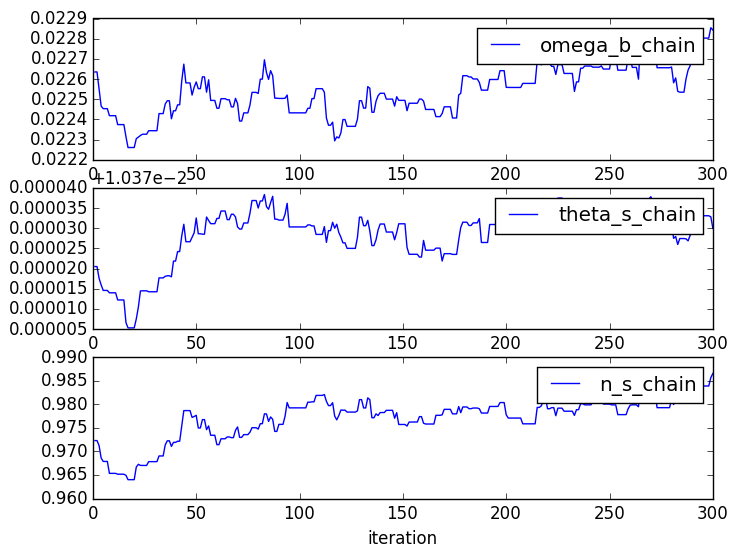

PyObject <matplotlib.legend.Legend object at 0x3384b6f10>

In [153]:
g = 0.015
αhist, uhist, θChain = MH(θ₀,dim,g);

μα = round(mean((αhist))*100.) * 0.01
μu = round(mean((uhist))*100.) * 0.01
omega_b_chain = θChain[:,1]
theta_s_chain = θChain[:,4]
n_s_chain     = θChain[:,6]

subplot(3,1,1)
plot(x,omega_b_chain, label = "omega_b_chain")

legend()
subplot(3,1,2)
plot(x,theta_s_chain, label = "theta_s_chain")

legend()
subplot(3,1,3)
plot(x,n_s_chain, label = "n_s_chain")
xlabel("iteration")
legend()

In [178]:
#plot(x[2:end],(αhist), label = "alpha (mu=$μα), g = $g")
#plot(x[2:end],(uhist), label = "u (mu=$μu), g = $g")
#xlabel("iteration")
#legend()
#θChain[:,1]

In [154]:
using PyCall, PyPlot
names_chain   = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s]
full_chain    = θChain
@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=full_chain, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true)

/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError('f(a) and f(b) must have different signs',)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/plots.py", line 1846, in triangle_plot
    add_legend_proxy=i == 0 and i2 == 1, contour_args=contour_args, **kwargs)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/plots.py", line 1068, in plot_2d
    **contour_args[i])
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/plots.py", line 862, in add_2d_contours
    likes=self.settings.shade_meanlikes)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/plots.py", line 552, in get_density_grid
    density = samples.get2DDensityGridData(param1.name, param2.name, num_plot_contours=conts, meanlikes=likes)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/mcsamples.py", line 1548, in get2DDensityGridData
    mult_bias_correction_order=mult_bias_correction_order)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/mcsamples.py", line 1113, in getAutoBandwidth2D
    opt = kde.KernelOptimizer2D(rotbins, N_eff, 0, do_correlation=not has_limits)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/getdist/kde_bandwidth.py", line 136, in __init__
    self.t_star = brentq(self._bandwidth_fixed_point_2D, 0, 0.1, xtol=0.001 ** 2)
  File "/Users/inchani/python/anaconda/lib/python2.7/site-packages/scipy/optimize/zeros.py", line 438, in brentq
    r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)

while loading In[154], in expression starting on line 8

In [175]:
function AI(θ₀::Array{Float64,1}, N::Int64, walkers, a=1.)
    Nwalkers = length(walkers[:,1])
    d      = length(θ₀)
    θ      = Array(Float64, N*Nwalkers, d)
    αhist  = Array(Float64, (N-1)*Nwalkers)    
    uhist  = Array(Float64, (N-1)*Nwalkers)   
    k = 1
    θ[1:Nwalkers,:] = walkers
    for i = 1:N-1 
        θ[Nwalkers*i+1:Nwalkers*(i+1),:] = walkers  # < Problem here ?
        for j = 1:Nwalkers
            z = ((√a - 1/√a) * rand() + 1/√a)^2     #  prop to 1/√z
            ind = rand(1:Nwalkers-1)
            if j >= ind 
                ind += 1
            end
            
            θprop = walkers[ind,:] + z .* (walkers[j,:] - walkers[ind,:]) # < Problem here ?
            u = log(rand())
            α = min( (d-1.)*log(z) + LogPost(θprop) - LogPost(walkers[j,:]), 0.)
            
            if u <= α
                θ[k+Nwalkers,:] = θprop # < Problem here ?
            end
            αhist[k] = α
            uhist[k] = u   
            
            k +=1
        end
    end
    return αhist, uhist, θ
end

AI (generic function with 2 methods)

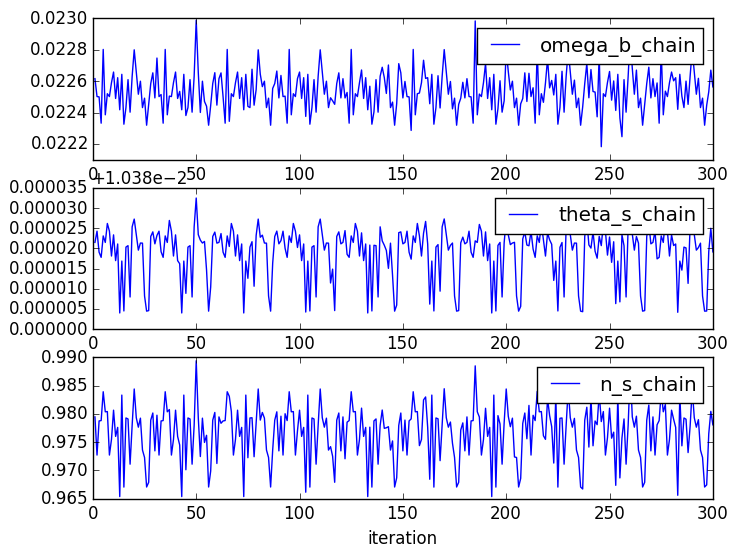

PyObject <matplotlib.legend.Legend object at 0x33da21550>

In [176]:
a = 2.5
dim = 10
Nwalkers = 30

ind = ceil(Int64, rand(Nwalkers)*(size(full_chain[:,1])[1] - 1) +1) 
walkers  = full_chain[ind,:]

αhist, uhist, θChain = AI(θ₀,dim,walkers,a);

using PyPlot
μα = round(mean(exp(αhist))*100.) * 0.01
μu = round(mean(exp(uhist))*100.) * 0.01
omega_b_chain = θChain[:,1]
theta_s_chain = θChain[:,4]
n_s_chain     = θChain[:,6]

x = linspace(1,length(n_s_chain),length(n_s_chain))
subplot(3,1,1)
plot(x,omega_b_chain, label = "omega_b_chain")

legend()
subplot(3,1,2)
plot(x,theta_s_chain, label = "theta_s_chain")

legend()
subplot(3,1,3)
plot(x,n_s_chain, label = "n_s_chain")
xlabel("iteration")
legend()

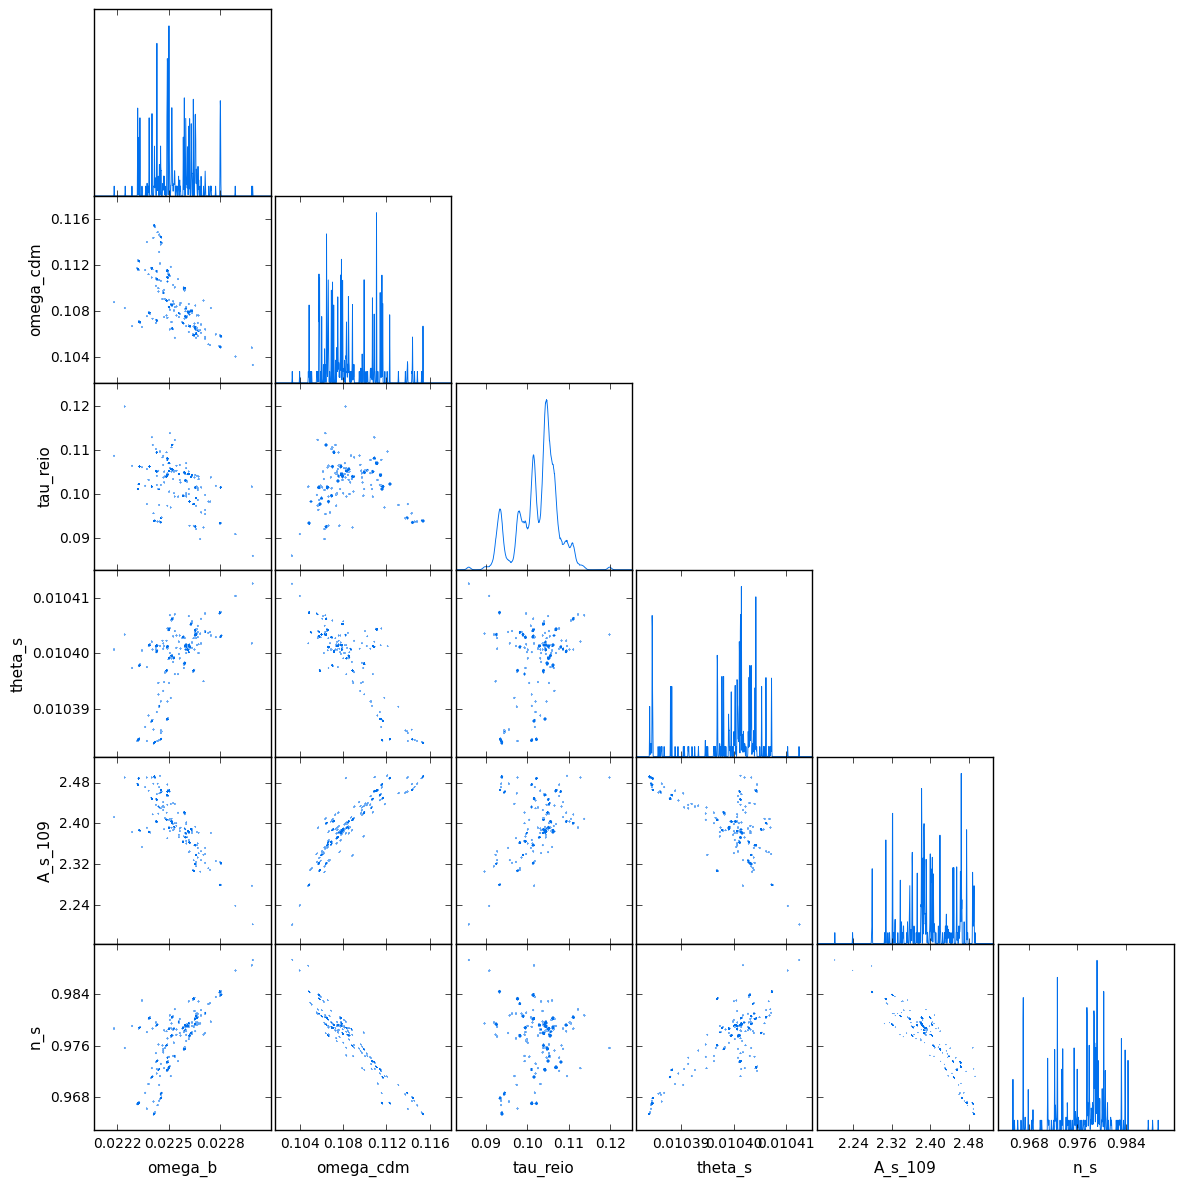

/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [177]:
using PyCall, PyPlot
names_chain   = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s]
full_chain    = θChain
@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=full_chain, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true)